<div class="alert alert-block alert-info">
<center> <h1> Text Mining - Predicting Airbnb Unlisting</h1> </center> <br>
<center> Group 17 </center>

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==================
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Parrinha (m20201320@novaims.unl.pt)
Pedro Anastácio (m20180040@novaims.unl.pt)
===========================================
```

**Table of Contents** <br>
* [1.Data Import](#IMPORT)
    * [1.1. Import Libraries](#LIBS)
    * [1.2. Import Datasets](#DATASETS)
* [2.Data Exploration](#EXPLORATION)
    * [2.1. Missing Data](#MISSING)
    * [2.2. Duplicates](#DUBS)
    * [2.3. Word Clouds](#WCLOUD)
    * [2.4. Word Count](#WCOUNT)
    * [2.5. Language Detection](#DETECTION)    
* [3.Data Preprocessing](#PRE)
* [4.Feature Engineering](#ENG)
    * [4.1. Bag of Words](#BOW)
    * [4.2. TF-IDF](#TFIDF)
        * [4.2.1. 1-Gram](#1GRAM)
        * [4.2.2. 2-Gram](#2GRAM)
* [5.Classification Models](#CLMODELS)
    * [5.1. KNN](#KNN)
    * [5.2. Random Forrest](#RDF)
    * [5.3. Naive Bayes](#NBAYES)
    * [5.4. Logistic Regression](#LGRE)
    * [5.5. Neural Networks](#NN)
* [6.Evaluation and Results](#EVAL)

<hr>
<a class="anchor" id="">
    
# 1. Data Import
    
</a>

<hr>
<a class="anchor" id="LIBS">
    
## 1.1. Import Libraries
    
</a>

In [144]:
import pandas as pd
import numpy as np
import csv
from tabulate import tabulate

from collections import Counter

# Profile Report
import pandas_profiling

# Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

# Clean Data
from bs4 import BeautifulSoup

#Tokenization
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer

#Punctuation
import string

#Stop Words
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('stopwords')

#Regular Expressions
import re

# Stemming and Lemmatization
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer

# Display progress bars during iterative tasks
from tqdm import tqdm

# Data Partition
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold

# Create BoW - Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Evaluate
from sklearn.metrics import classification_report

# confusion_matrix
from sklearn.metrics import confusion_matrix

# Translator
from langdetect import detect
from googletrans import Translator
import os
from transformers import MarianMTModel, MarianTokenizer
from translate import Translator

# Remove emoji
import emoji

# Scaller
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Fine Tuning
from sklearn.model_selection import GridSearchCV

# To avoid have warnings
import warnings
warnings.filterwarnings("ignore")

<hr>
<a class="anchor" id="DATASETS">
    
## 1.2. Import Datasets
    
</a>

In [145]:
df_train = pd.read_excel('/Users/pedroanastacio/TM_project/Project Corpora/train.xlsx')
df_test = pd.read_excel('/Users/pedroanastacio/TM_project/Project Corpora/test.xlsx')
df_reviews_train = pd.read_excel('/Users/pedroanastacio/TM_project/Project Corpora/train_reviews.xlsx')
df_reviews_test = pd.read_excel('/Users/pedroanastacio/TM_project/Project Corpora/test_reviews.xlsx')

In [146]:
#df_train.head()
#df_test.head()
#df_reviews_train.head()
df_reviews_test.head()

index                                           comments
0      1  Thank you very much Antonio ! All has been per...
1      1  Very nice appartment in the old town of Lissab...
2      1  When travelling we're looking for kids friendl...
3      1  We've been in Lisbon in march 2013 (3 adults a...
4      1  Our host Antonio was very helpful with informa...

In [147]:
# Set Index
df_train = df_train.set_index('index')
df_test = df_test.set_index('index')
#df_reviews_train = df_reviews_train.set_index('index')
#df_reviews_test = df_reviews_test.set_index('index')

In [148]:
#df_train.head()
#df_test.head()
df_reviews_train.head() 
#df_reviews_test.head()

index                                           comments
0      1  this is a very cozy and comfortable house to s...
1      1                                          good<br/>
2      1  My first hostel experience, and all I have to ...
3      1  Das Hostel war neu und deshalb funktionierte a...
4      1  It was fine for a dorm, but I think for the pe...

<hr>
<a class="anchor" id="EXPLORATION">
    
# 2. Data Exploration
    
</a>

In [149]:
# Generate a profile report for the df_train DataFrame
df_train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [150]:
(df_train["unlisted"]).unique()

array([0, 1])

<div class="alert alert-block alert-success">
    The target variable has 2 unique values

In [151]:
(df_train['unlisted']).describe()

count    12496.000000
mean         0.277129
std          0.447598
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: unlisted, dtype: float64

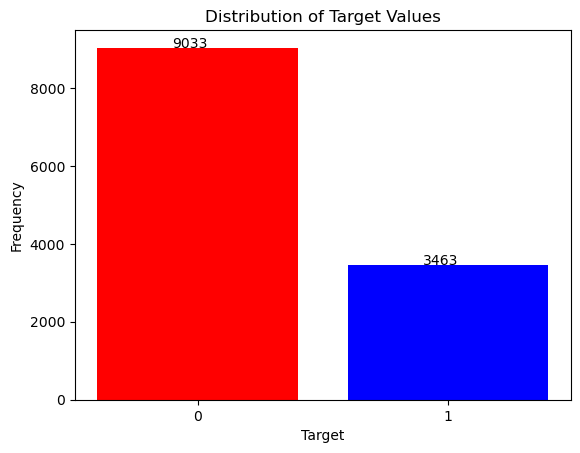

In [152]:
# Calculate the frequency of each rating
counts = df_train['unlisted'].value_counts()

# Create a bar chart of the ratings
colors = ['red', 'blue']
plt.bar(counts.index, counts.values, color=colors)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Target Values')
plt.xticks(range(0, 2))

# Add the value of each bar to the plot
for i, v in enumerate(counts.values):
    plt.text(counts.index[i] - 0.1, v + 0.1, str(v))

plt.show()

In [153]:
df_train['unlisted'].value_counts(normalize = True)

0    0.722871
1    0.277129
Name: unlisted, dtype: float64

<div class="alert alert-block alert-danger">  
The <b>train</b> dataset has an unbalanced Target variable with 72.3% of the data being "0"
</div>

In [154]:
df_reviews_train.describe().T

count         mean          std  min     25%     50%     75%  \
index  721402.0  6212.577535  3604.810218  1.0  3058.0  6242.0  9265.0   

           max  
index  12494.0

<div class="alert alert-block alert-success">
    There are <b>721.402</b> comments

<a class="anchor" id="MISSING">

## 2.1. Missing Data

</a>

In [155]:
df_train.isna().sum()

description    0
host_about     0
unlisted       0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in any of the features in the <b> train </b> dataset
</div>

In [156]:
df_reviews_train.isna().sum()

index       0
comments    0
dtype: int64

<div class="alert alert-block alert-success">
    There are no missing values in the <b> train_reviews </b> dataset
</div>

<a class="anchor" id="DUBS">

## 2.2. Duplicates

</a>

<a class="anchor" id="DUBSTRAIN">

### 2.2.1. Description and host

</a>

In [157]:
# Are there any duplicate rows in df_train
df_train.duplicated().any()

True

In [158]:
# What percentage of the rows are duplicates
duplicate_percentage = df_train.duplicated().mean() * 100
print(f"The percentage of duplicate rows in df_train is: {duplicate_percentage:.2f}%")

The percentage of duplicate rows in df_train is: 4.90%


In [159]:
# Compare the number of duplicates with the total number of rows
duplicated_rows = df_train[df_train.duplicated()]
num_duplicated_rows = duplicated_rows.shape[0]
total_rows = df_train.shape[0]

print("Number of duplicated rows:", num_duplicated_rows)
print("Total number of rows:", total_rows)

Number of duplicated rows: 612
Total number of rows: 12496


In [160]:
# Display the duplicated rows
duplicated_rows = df_train[df_train.duplicated()]
print("Duplicated rows:")
print(duplicated_rows)

Duplicated rows:
                                                description  \
df_index                                                      
232       Nesha Guesthouse Lisbon is a surf & beach orie...   
550       We are The Salty Pelican Yoga & Surf Retreat. ...   
726       Hospede-se em um local privilegiado e aconcheg...   
977       This gorgeous and spacious room located right ...   
993       Located in the heart of Lisbon (in the histori...   
...                                                     ...   
12438     Quiet place 12 minutes driving from the airpor...   
12453     Located in Chiado district, one of the trendie...   
12462     The <b>apartment in Ericeira</b> has 1 bedroom...   
12467     Arrendamento mensal. Quarto mobilado e climati...   
12478     Our bed and breakfast is located within the Te...   

                                                 host_about  unlisted  
df_index                                                               
232       I'm an en

In [161]:
# Create a df with the duplicate rows and a column with the number of times a specific row repeats
duplicated_rows = df_train[df_train.duplicated()]
duplicate_counts = duplicated_rows.value_counts().reset_index()
duplicate_counts.columns = df_train.columns.tolist() + ['Number of times row repeats']

duplicate_counts_df = pd.DataFrame(duplicate_counts)
duplicate_counts_df.head()

description  \
0  Arrendamento mensal. Quarto mobilado e climati...   
1  Set in a stunning seaside location, this luxur...   
2  Set in a stunning seaside location, this luxur...   
3  Saldanha Prestige is a classy and quality apar...   
4  It’s in the light that bathes the Tagus river ...   

                                          host_about  unlisted  \
0  Hello! We are Luzeiros Suites located on Aveni...         1   
1  Going someplace new is always exciting. And wh...         0   
2  Going someplace new is always exciting. And wh...         0   
3  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0   
4  Madalena Orquídea Living nasce da reabilitação...         0   

   Number of times row repeats  
0                            9  
1                            8  
2                            8  
3                            7  
4                            7

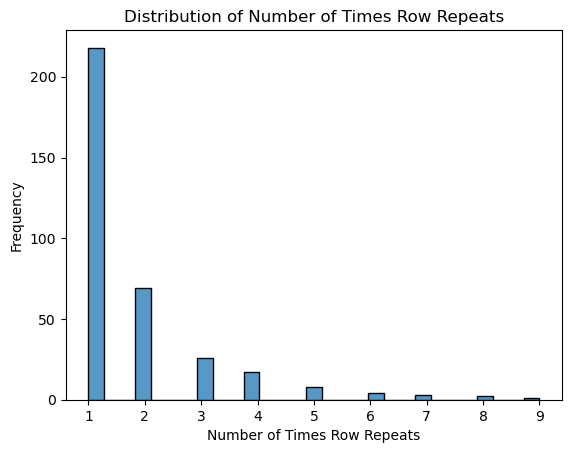

In [162]:
# Plot the distribution of 'Number of times row repeats'
sns.histplot(data=duplicate_counts_df, x='Number of times row repeats')

# Set plot labels and title
plt.xlabel('Number of Times Row Repeats')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Times Row Repeats')

# Display the plot
plt.show()

In [163]:
# Explore duplicate rows
duplicated_rows = df_train[df_train.duplicated()]
duplicate_counts = duplicated_rows.value_counts().reset_index()
duplicate_counts.columns = df_train.columns.tolist() + ['Count']

duplicate_counts_table = tabulate(duplicate_counts, headers='keys', tablefmt='psql')

print("Duplicate Counts:")
print(duplicate_counts_table)

Duplicate Counts:
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [164]:
print('Number of duplicate rows in df_train["description"]')
print(df_train["description"].duplicated().sum())
print('Number of duplicate rows in df_train["host_about"]')
print(df_train["host_about"].duplicated().sum())

Number of duplicate rows in df_train["description"]
708
Number of duplicate rows in df_train["host_about"]
8100


<div class="alert alert-block alert-success">
    We assume from the previous finding that a single host has multiple properties
</div>

<a class="anchor" id="DUBSREVIEW">

### 2.2.2. Comments

</a>

In [165]:
# Are there any duplicate rows in df_reviews_train
df_reviews_train.duplicated().any()

True

In [168]:
# What percentage of the rows are duplicates
duplicate_percentage = df_reviews_train.duplicated().mean() * 100
print(f"The percentage of duplicate rows in df_reviews_train is: {duplicate_percentage:.2f}%")

The percentage of duplicate rows in df_reviews_train is: 0.04%


In [169]:
# Compare the number of duplicates with the total number of rows
duplicated_rows = df_reviews_train[df_reviews_train.duplicated()]
num_duplicated_rows = duplicated_rows.shape[0]
total_rows = df_reviews_train.shape[0]

print("Number of duplicated rows:", num_duplicated_rows)
print("Total number of rows:", total_rows)

Number of duplicated rows: 305
Total number of rows: 721402


In [170]:
# Display the duplicated rows
duplicated_rows = df_reviews_train[df_reviews_train.duplicated()]
print("Duplicated rows:")
print(duplicated_rows)

Duplicated rows:
        index                                           comments
3254       61                                         Excelente!
4263       70                              Everything was great!
6586      144  Sofia is an incredible host, and made us feel ...
7362      156                                                  .
12962     254                                                  .
...       ...                                                ...
711344  12287                                              Super
715124  12377                                                  .
720042  12464                                   Boa localização.
721188  12493                                    Great location!
721275  12494                                                  .

[305 rows x 2 columns]


In [143]:
# Create a df with the duplicate rows and a column with the number of times a specific row repeats
duplicated_rows = df_reviews_train[df_reviews_train.duplicated()]
duplicate_counts = duplicated_rows.value_counts().reset_index()
duplicate_counts.columns = df_reviews_train.columns.tolist() + ['Number of times row repeats']

duplicate_counts_df_reviews = pd.DataFrame(duplicate_counts)
duplicate_counts_df_reviews.head(20)

comments  \
0                                                   .   
1                                     Great location!   
2                                      Great location   
3                                        Great place!   
4                                         Great place   
5                                                Good   
6                                                   -   
7                                               Great   
8                                             Perfect   
9                                              Great!   
10                                                Top   
11                                        Great stay!   
12  The host canceled this reservation the day bef...   
13                                          Excelente   
14  The host canceled this reservation 2 days befo...   
15                                         Nice place   
16                                          Muito bom   
17                                            Parfait   
18                                          Très bien   
19                                                  👍   

    Number of times row repeats  
0                           907  
1                           255  
2                           248  
3                           214  
4                           182  
5                           157  
6                           152  
7                           130  
8                           129  
9                           122  
10                          117  
11                          117  
12                          114  
13                          110  
14                          108  
15                          104  
16                           93  
17                           93  
18                           89  
19                           89

<a class="anchor" id="WCLOUDS">

## 2.3. World Clouds

</a>

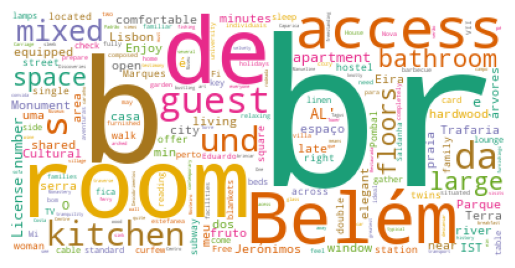

In [26]:
# Word Cloud of the feature "description" from df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500, 
    colormap='Dark2',
    contour_width=4).generate(str(df_train["description"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

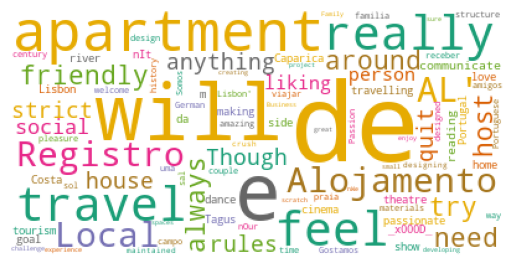

In [27]:
# Word Cloud of "host_about" from df_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500,
    colormap='Dark2',
    contour_width=4).generate(str(df_train["host_about"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

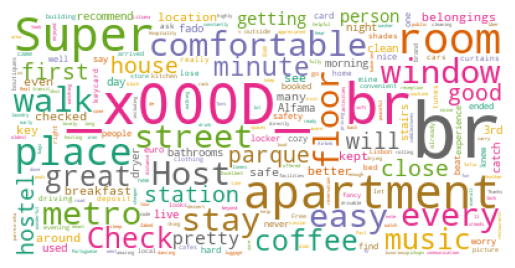

In [28]:
# Word Cloud of "comments" from df_reviews_train
wordcloud = WordCloud(
    background_color='white', 
    max_words=500,
    colormap='Dark2',
    contour_width=4).generate(str(df_reviews_train["comments"].values))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<a class="anchor" id="WCOUNT">

## 2.4. Word Count

</a>

In [29]:
# Wordcount of each row
df_train["description_count"]  = df_train["description"].apply(lambda x: len(str(x).split(" ")))
df_train["host_count"]  = df_train["host_about"].apply(lambda x: len(str(x).split(" ")))
df_reviews_train["comments_count"]  = df_reviews_train["comments"].apply(lambda x: len(str(x).split(" ")))
df_train.head()

description  \
df_index                                                      
1         This is a shared mixed room in our hostel, wit...   
2         O meu espaço fica perto de Parque Eduardo VII,...   
3         Trafaria’s House is a cozy and familiar villa ...   
4         Apartamento Charmoso no Chiado, Entre o Largo ...   
5         Joli appartement  en bordure de mer.<br /> 2 m...   

                                                 host_about  unlisted  \
df_index                                                                
1                       Alojamento Local Registro: 20835/AL         0   
2         I am friendly host, and I will try to always b...         1   
3         I am a social person liking to communicate, re...         1   
4         Hello!_x000D_\nI m Portuguese and i love to me...         0   
5         Nous sommes une famille avec deux enfants de 1...         0   

          description_count  host_count  
df_index                                 
1                       127           4  
2                        23          24  
3                       170          45  
4                        47          31  
5                       101          37

In [30]:
df_reviews_train.head()

comments  comments_count
index                                                                   
1      this is a very cozy and comfortable house to s...              28
1                                              good<br/>               1
1      My first hostel experience, and all I have to ...             261
1      Das Hostel war neu und deshalb funktionierte a...              81
1      It was fine for a dorm, but I think for the pe...              27

In [31]:
# Frequency of individual words in each feature
allDescriptionW = ' '.join(df_train["description"]).split()
allHostW = ' '.join(df_train['host_about']).split()
freqDescripW = pd.Series(allDescriptionW).value_counts()
freqHostW = pd.Series(allHostW).value_counts()

**Description**

In [32]:
# Descriptive statists for word count
df_train.description_count.describe()

count    12496.000000
mean       132.663572
std         48.494104
min          3.000000
25%         99.000000
50%        157.000000
75%        167.000000
max        210.000000
Name: description_count, dtype: float64

In [33]:
freqDescripW.sort_values(ascending=False)[0:10]

the      62717
and      54907
a        50700
/><br    34826
to       30520
of       30050
in       28007
with     27033
is       23957
de       13708
dtype: int64

<AxesSubplot:>

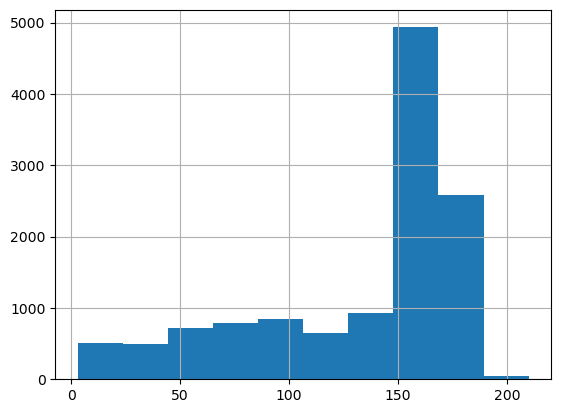

In [34]:
df_train["description_count"].hist()

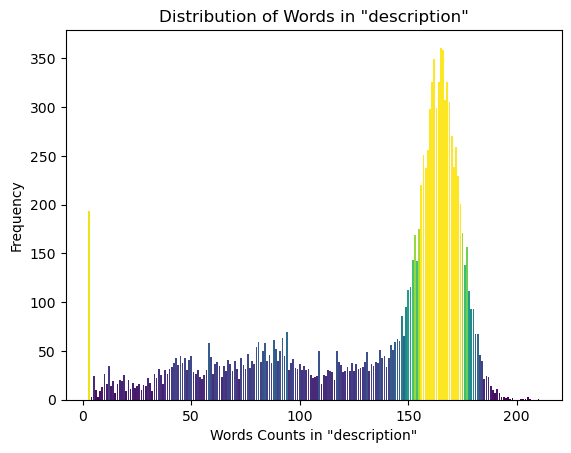

In [35]:
# Calculate the frequency of each rating
counts_desc = df_train['description_count'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_desc.index, counts_desc.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "description"')
plt.ylabel('Frequency')
plt.title('Distribution of Words in "description"')

plt.show()

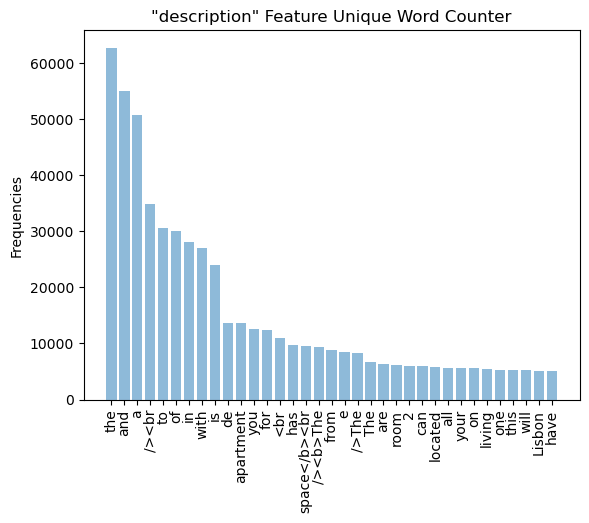

In [36]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqDescripW.index[0:35]
values = freqDescripW[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"description" Feature Unique Word Counter')

plt.show()

**host_about**

In [37]:
df_train.host_count.describe()

count    12496.000000
mean        73.031050
std         77.132867
min          1.000000
25%         26.000000
50%         55.000000
75%        102.000000
max       1387.000000
Name: host_count, dtype: float64

In [38]:
freqHostW.sort_values(ascending=False)[0:10]

and    32569
to     26540
the    21488
a      21184
in     19515
I      12752
of     12752
you    12511
de      8739
We      8457
dtype: int64

<AxesSubplot:>

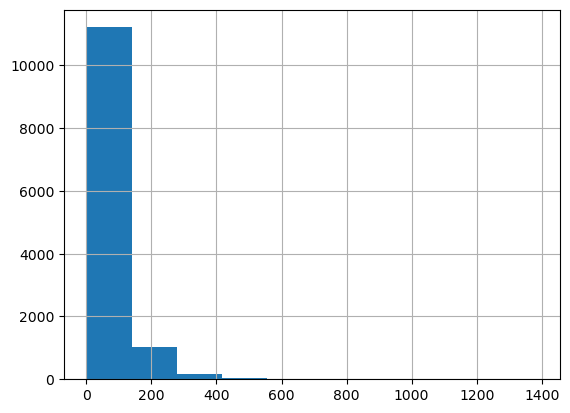

In [39]:
df_train["host_count"].hist()

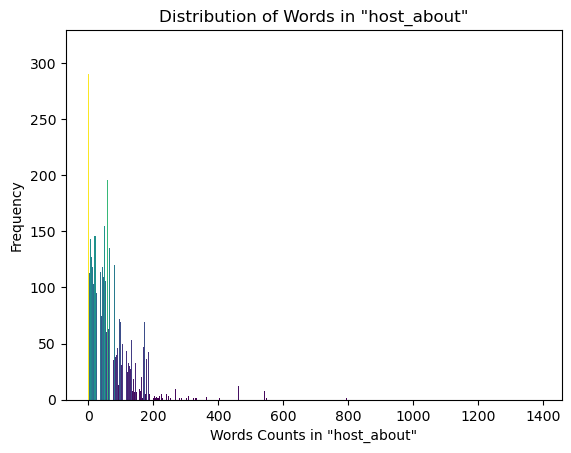

In [40]:
# Calculate the frequency of each rating
counts_desc = df_train['host_count'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_desc.index, counts_desc.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "host_about"')
plt.ylabel('Frequency')
plt.title('Distribution of Words in "host_about"')

plt.show()

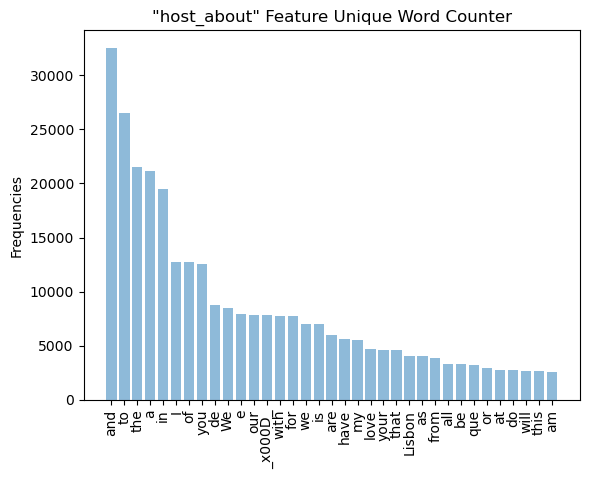

In [41]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqHostW.index[0:35]
values = freqHostW[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"host_about" Feature Unique Word Counter')

plt.show()

**Comments**

In [42]:
df_reviews_train.comments_count.describe()

count    721402.000000
mean         47.993793
std          46.922807
min           1.000000
25%          18.000000
50%          36.000000
75%          63.000000
max        1064.000000
Name: comments_count, dtype: float64

<AxesSubplot:>

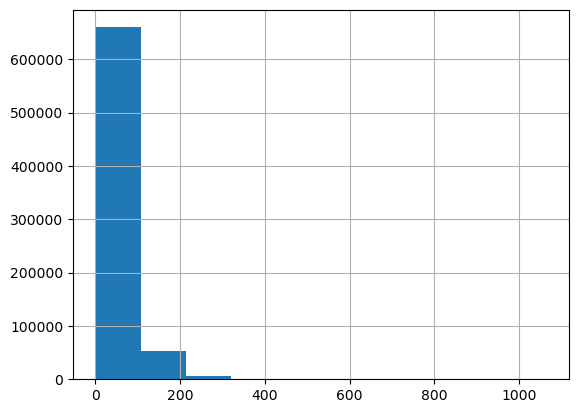

In [43]:
df_reviews_train["comments_count"].hist()

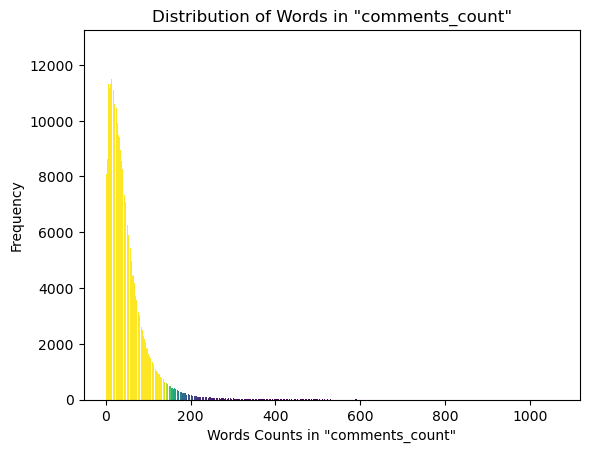

In [44]:
# Calculate the frequency of each rating
counts_desc = df_reviews_train['comments_count'].value_counts()

# Create a colormap based on the frequencies
colormap = cm.get_cmap('viridis', len(counts_desc))

# Create a bar chart of the ratings
plt.bar(counts_desc.index, counts_desc.values, color=colormap(counts_desc.values))
plt.xlabel('Words Counts in "comments_count"')
plt.ylabel('Frequency')
plt.title('Distribution of Words in "comments_count"')

plt.show()

In [45]:
# Checking if there are rows where 'comments' is numberic
numeric_column = pd.to_numeric(df_reviews_train['comments'], errors='coerce')
numeric_rows = df_reviews_train[~numeric_column.isna()] # rows with successful conversion
numeric_rows.head()

comments  comments_count
index                         
468         10               1
1062         1               1
1397         1               1
2696         0               1
3593         9               1

<div class="alert alert-block alert-danger">  
Given that some rows in the feature "comments" are numeric convert the feature to string
</div>

In [46]:
# Change the type of the column "comments" to string
df_reviews_train['comments'] = df_reviews_train['comments'].astype('string')

In [47]:
# Frequency of individual words for "comments"
allCommentsW = ' '.join(df_reviews_train["comments"]).split()
freqCommentsW = pd.Series(allCommentsW).value_counts()

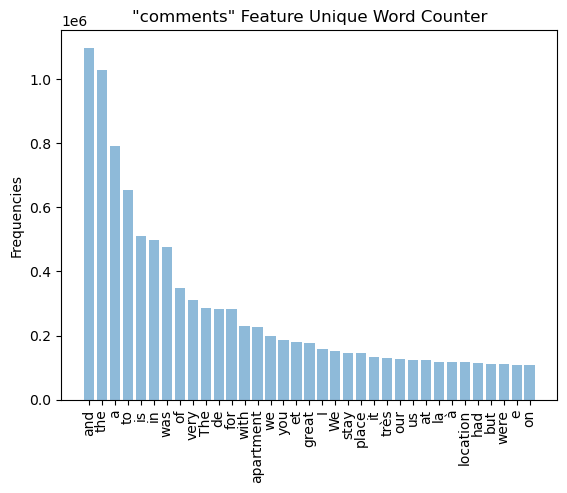

In [48]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqCommentsW.index[0:35]
values = freqCommentsW[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"comments" Feature Unique Word Counter')

plt.show()

<a class="anchor" id="DETECTION">

## 2.5. Language Detection

</a>

In [49]:
def detect_language(text):
    try:
        lang = detect(text)  # Attempt to detect the language of the given text
    except:  # Handle any exception that occurs during language detection
        lang = None  # Set the language to None if an exception is raised
    return lang  # Return the detected language or None if detection failed

In [208]:
# Save df_train DataFrame to a CSV file
df_train.to_csv('output/train.csv', index=False)

# Save df_reviews_train DataFrame to a CSV file
df_reviews_train.to_csv('output/train_reviews.csv', index=False)

In [209]:
# Detecting languages of features in df_train
source_file = 'output/train.csv'  # Path to the source CSV file
destination_file = 'output/train_language.csv'  # Path to the destination CSV file

chunk_size = 1000  # Number of rows to process at a time
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)  # Create an iterator to read the CSV in chunks

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    # Detect language for the 'description' and 'host_about' columns in the current chunk
    chunk['description_language'] = chunk['description'].apply(detect_language)
    chunk['host_language'] = chunk['host_about'].apply(detect_language)
    
    # Write the processed chunk to the destination file
    chunk.to_csv(destination_file,
                 index=False,
                 mode='a',
                 header=not os.path.exists(destination_file))


13it [01:48,  8.33s/it]


In [50]:
df_train = pd.read_csv('output/train_language.csv')
df_train.head()

description  \
0  Com uma localização exclusiva entre a Vila de ...   
1  Hello traveler, if you are looking for the per...   
2  In the Lapa district, Lisbon's noble area, you...   
3  Um Lugar ao Sol (Place in the Sun) Beach House...   
4  Perfeito para 2 pessoas, muito aconchegante, c...   

                                          host_about  unlisted  \
0  Hello, I'm José. Well prepared and traveled I ...         1   
1  Hi world, my name is João Figueira, I am 35 ye...         0   
2  Travelling, decorating spaces, eating and meet...         1   
3  We are a couple who loves to travel and meet o...         0   
4  Don’t worry be Happy , we are here in the suns...         1   

   description_count  host_count description_language host_language  
0                 86          26                   pt            en  
1                157         170                   en            en  
2                 53          36                   en            en  
3                178          96                   en            en  
4                158          38                   pt            en

In [211]:
# Detecting languages of the feature "comments" in df_reviews_train
source_file = 'output/train_reviews.csv'  # Path to the source CSV file
destination_file = 'output/reviews_language.csv'  # Path to the destination CSV file

chunk_size = 1000  # Number of rows to process at a time
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)  # Create an iterator to read the CSV in chunks

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    # Detect language for the 'comments' column in the current chunk
    chunk['comments_language'] = chunk['comments'].apply(detect_language)
    
    # Write the processed chunk to the destination file
    chunk.to_csv(destination_file,
                 index=False,
                 mode='a',
                 header=not os.path.exists(destination_file))

722it [38:01,  3.16s/it]


In [52]:
df_reviews_train = pd.read_csv('output/reviews_language.csv')
df_reviews_train.iloc[1000:1110, :]

comments  comments_count  \
1000  A well equipt, clean unit in an ideal location...              53   
1001                                       Great place!               2   
1002  Joao and his colleagues are all very kind and ...              51   
1003  L'appartement est très bien. L'agence est top ...              16   
1004  1ère visite de Lisbonne: le logement est situé...              73   
...                                                 ...             ...   
1105  Newly, well located, fully equipped and clean ...              24   
1106  Very nice place! Great location, very helpful ...              26   
1107  The appartement was pretty and of good taste o...              44   
1108    Wonderful little apartment in a beautiful city!               7   
1109  Marce, es una gran anfitriona muy preocupada p...              26   

     comments_language  
1000                en  
1001                en  
1002                en  
1003                fr  
1004                fr  
...                ...  
1105                en  
1106                en  
1107                en  
1108                en  
1109                es  

[110 rows x 3 columns]

**description**

In [53]:
# How many languages are in the feature "description" of df_train
description_language = df_train['description_language'].unique()
print(description_language)

['pt' 'en' 'fr' 'da' 'de' 'es' 'it' 'ca' 'no' 'nl' 'sv' 'ru' 'pl' 'zh-cn']


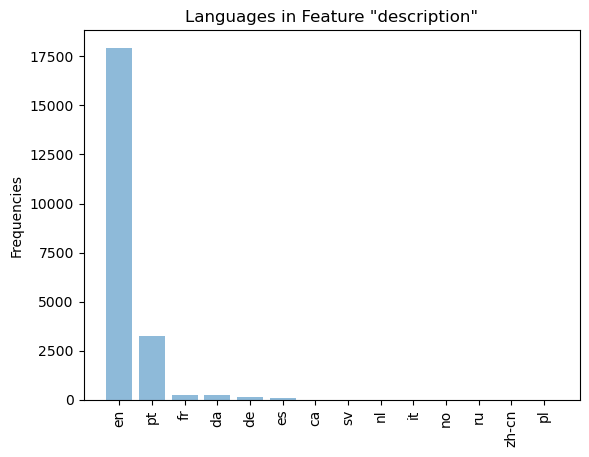

In [54]:
# Calculate the frequency of each language in the 'description_language' column
freq = pd.Series(df_train['description_language']).value_counts()

# Select the top 20 language frequencies and their corresponding labels
x_labels = freq.index[0:20]
values = freq[:20]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the y-axis label
plt.ylabel('Frequencies')

# Set the title of the plot
plt.title('Languages in Feature "description"')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

**host_about**

In [55]:
# How many languages are in the feature "host_about" of df_train
host_language = df_train['host_language'].unique()
print(host_language)

['en' 'pt' 'de' 'fr' 'es' 'it' 'sk' 'ca' nan 'zh-cn' 'so' 'ro' 'no' 'fi'
 'tr' 'af' 'et' 'sw' 'sl' 'he' 'vi' 'tl' 'nl' 'id' 'hr' 'ru' 'cs' 'hu'
 'zh-tw' 'da' 'lt' 'sv' 'ko']


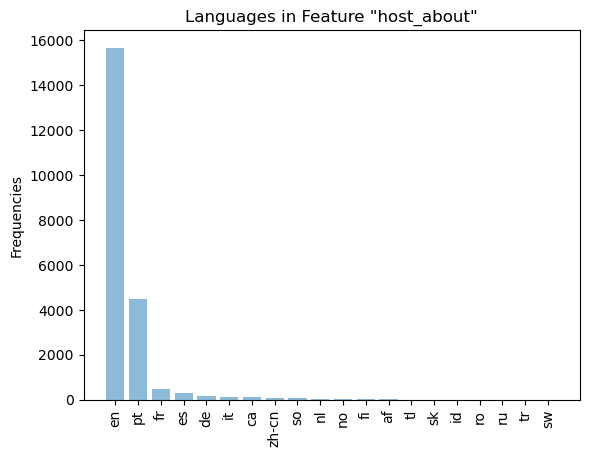

In [56]:
# Calculate the frequency of each language in the 'host_language' column
freq = pd.Series(df_train['host_language']).value_counts()

# Select the top 20 language frequencies and their corresponding labels
x_labels = freq.index[0:20]
values = freq[:20]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the y-axis label
plt.ylabel('Frequencies')

# Set the title of the plot
plt.title('Languages in Feature "host_about"')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

**comments**

In [57]:
# How many languages are in the feature "host_about" of df_train
comments_language = df_reviews_train['comments_language'].unique()
print(comments_language)

['en' 'cy' 'de' 'fr' 'es' 'pt' 'ru' 'nl' 'it' 'ko' 'zh-cn' 'he' nan 'id'
 'pl' 'no' 'so' 'da' 'sq' 'ro' 'ca' 'hr' 'ja' 'zh-tw' 'tl' 'cs' 'ar' 'af'
 'sk' 'sv' 'lv' 'hu' 'el' 'sl' 'fi' 'tr' 'sw' 'vi' 'uk' 'lt' 'et' 'bg'
 'mk' 'ur' 'th' 'hi' 'ne']


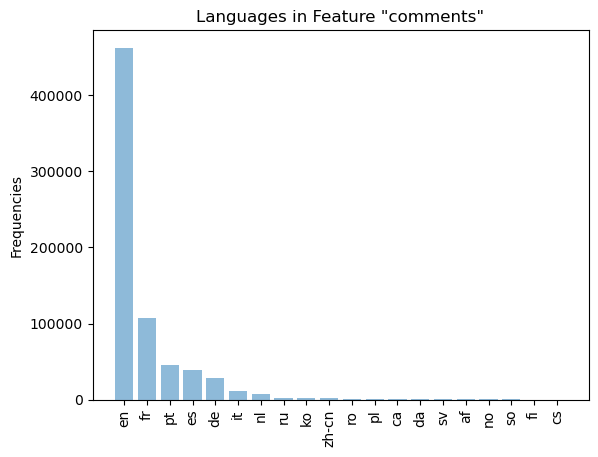

In [58]:
# Calculate the frequency of each language in the 'comments' column
freq = pd.Series(df_reviews_train['comments_language']).value_counts()

# Select the top 20 language frequencies and their corresponding labels
x_labels = freq.index[0:20]
values = freq[:20]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the y-axis label
plt.ylabel('Frequencies')

# Set the title of the plot
plt.title('Languages in Feature "comments"')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

### Summary of Exploratory Analysis

The original 'train' dataset contains 12496 rows and 4 columns: 'index', 'description', 'host_about', 'unlisted'. The 'unlisted' column is the target variable and is to be predicted based on other values.

Based on the wordclouds, it can be seen that the given dataset contains languages other then English - at least Portuguese(see the words like 'de', 'e', 'Alojamento', 'Belém', 'praia') and German('und', 'ist' and others). Also, there is a number of tags (such as "\<br />" and "\<b>") in our data as well as sequences of characters that are obtained after import from an Excel file (such as "_x000D_\n"). 
 
The dataset does not have any empty values. 

It turned out, some rows have the same values for both 'description' and 'host_about' columns, wheras 'unlisted' values are different. It means that using only 'train' dataset might be not enough for the project purpose and we might want to utilize 'reviews' data as well.

<a class="anchor" id="VIZ">

## 3. Preprocessing

</a>

Apply at least 4 techniques

### Steps to be explored
- Remove the noise by applying BeautifulSoup (removes HTML tags)
- Regular expressions (Remove Punctuation; Set all characters to lowercase;Remove numbers (or convert numbers to text)
- Remove stopwords
- Normalize (apply Stemmer or Lemmatizer)
- Remove emojis or convert them to text format
- Translation

In [59]:
# Creating a function to remove HTML tags
def remove_HTML_tags(df, column):
    """Function that removes HTML tags from a column containing strings in a dataframe."""
    # Remove HTML tags from df[column] using BeautifulSoup
    df[column] = df[column].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" ") if isinstance(x, str) else x)

    # Remove extra whitespaces and newline characters from df[column]
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
    
    return df

In [62]:
# Creating a function to test different preProcessing strategies

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def clean(df, columns, remove_stopwords=True, remove_punctuation=True, remove_more_numbers=True,
          convert_lowercase=True, remove_numbers=False, normalize=False, use_lemmatizer=False,
          use_stemmer=False, remove_emoji=True):
    stemmer = PorterStemmer() if use_stemmer else None
    lemmatizer = WordNetLemmatizer() if use_lemmatizer else None

    nltk_stopwords = {
        'en': stopwords.words('english'),
        'pt': stopwords.words('portuguese'),
        'de': stopwords.words('german'),
        'fr': stopwords.words('french'),
        'es': stopwords.words('spanish'),
        'it': stopwords.words('italian'),
        'sk': ['a', 'aby', 'aj', 'ak', 'ako', 'ale', 'alebo', 'and', 'ani', 'áno', 'asi', 'až', 'bez', 'bol',
               'bola', 'boli', 'bolo', 'by', 'byť', 'cez', 'či', 'ďalší', 'do', 'ho', 'hoci', 'i', 'iba', 'iné',
               'iný', 'ja', 'je', 'jeho', 'jej', 'jemu', 'ju', 'k', 'kam', 'každý', 'kde', 'keď', 'kto', 'ktorý',
               'ku', 'lebo', 'len', 'ma', 'mať', 'má', 'máte', 'medzi', 'mi', 'mňa', 'mne', 'mnou', 'moja', 'moje',
               'mojej', 'mojich', 'mojím', 'mojím', 'mu', 'musieť', 'môcť', 'môj', 'môže', 'na', 'nad', 'nám', 'náš',
               'naše', 'naši', 'ne', 'neho', 'než', 'nič', 'nie', 'niektorý', 'nielen', 'nim', 'nimi', 'nižšie', 'no',
               'nové', 'nový', 'o', 'od', 'odo', 'on', 'ona', 'oni', 'ono', 'ony', 'po', 'pod', 'podľa', 'pokiaľ',
               'potom', 'práve', 'pre', 'prečo', 'pred', 'predo', 'preto', 'pretože', 'prečo', 'pri', 's', 'sa', 'so',
               'si', 'sme', 'sme', 'so', 'som', 'som', 'sú', 'svoj', 'svoje', 'svojich', 'svojím', 'svojím', 'ta',
               'tak', 'takže', 'tam', 'te', 'té', 'ten', 'tento', 'the', 'tie', 'tieto', 'tiež', 'to', 'toho', 'tohoto',
               'tom', 'tomto', 'tomu', 'tomuto', 'toto', 'tu', 'tú', 'túto', 'tvoj', 'ty', 'tvojím', 'u', 'už', 'v',
               'vám', 'váš', 'váš', 'veľmi', 'viac', 'vo', 'však', 'všetok', 'vy', 'z', 'za', 'začo', 'zo', 'že'],        
        'ca': stopwords.words('catalan'),
        'zh-cn': stopwords.words('chinese'),
        'ro': stopwords.words('romanian'),
        'no': stopwords.words('norwegian'),
        'fi': stopwords.words('finnish'),
        'tr': stopwords.words('turkish'),
        'et': ['aga', 'ei', 'et', 'ega', 'ja', 'jah', 'kas', 'kui', 'kuid', 'kuni', 'kõik', 'ma', 'me', 'mida', 'midagi',
    'mind', 'minu', 'mis', 'mu', 'mul', 'mulle', 'nad', 'nii', 'oled', 'olen', 'oli', 'oma', 'on', 'pole', 'sa',
    'seda', 'see', 'selle', 'siin', 'siis', 'ta', 'te', 'ära'],
        'sw': ['akasema', 'alikuwa', 'alisema', 'baada', 'basi', 'bila', 'cha', 'chini', 'hadi', 'hapo', 'hata', 'hivyo', 'huo',
    'ili', 'ilikuwa', 'juu', 'kama', 'karibu', 'katika', 'kila', 'kima', 'kisha', 'kubwa', 'kutoka', 'kuwa', 'kwa',
    'kwamba', 'kwenda', 'kwisha', 'la', 'lakini', 'mara', 'mdogo', 'mimi', 'mkubwa', 'mmoja', 'moja', 'muda', 'mwenye',
    'na', 'naye', 'ndani', 'ng', 'ni', 'nini', 'nonkungu', 'pamoja', 'pia', 'sana', 'sasa', 'sauti', 'tafadhali', 'tena',
    'tu', 'vile', 'wa', 'wakati', 'wake', 'wale', 'walikuwa', 'wao', 'watu', 'wengine', 'wote', 'ya', 'yake', 'yangu',
    'yao', 'yeye', 'yule', 'za', 'zaidi', 'zake'],
        'sl': stopwords.words('slovene'),
        'he': stopwords.words('hebrew'),
        'vi': ['ai', 'biết', 'bằng', 'bằng_cách', 'cả', 'các', 'cái', 'chúng', 'chúng_ta', 'chưa', 'có', 'cũng', 'đã', 'đang',
    'đây', 'để', 'gì', 'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mình', 'muốn', 'này', 'nên', 'nếu', 'ngay',
    'nhiều', 'như', 'nhưng', 'nơi', 'nữa', 'phải', 'qua', 'ra', 'rằng', 'rất', 'sau', 'sẽ', 'so', 'sự', 'tại', 'theo',
    'thì', 'trên', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'vì', 'việc', 'với', 'vừa', 'ý', 'được'],
        'tl': ['ako', 'amin', 'aming', 'ang', 'ano', 'anumang', 'apat', 'at', 'atin', 'ating', 'ay', 'bababa', 'bago', 'bakit',
    'bawat', 'bilang', 'dahil', 'dalawa', 'dapat', 'din', 'dito', 'doon', 'gagawin', 'gayunman', 'ginagawa', 'ginawa',
    'ginawang', 'gumawa', 'gusto', 'habang', 'hanggang', 'hindi', 'huwag', 'iba', 'ibaba', 'ibabaw', 'ibig', 'ikaw',
    'ilagay', 'ilan', 'inyong', 'isa', 'isang', 'itaas', 'ito', 'iyo', 'iyon', 'iyong', 'ka', 'kahit', 'kailangan',
    'kailanman', 'kami', 'kanila', 'kanilang', 'kanino', 'kanya', 'kanyang', 'kapag', 'kapwa', 'karamihan', 'katiyakan',
    'katulad', 'kay', 'kaya', 'kaysa', 'ko', 'kong', 'kulang', 'kumuha', 'kung', 'laban', 'lahat', 'lamang', 'likod',
    'lima', 'maaari', 'maaaring', 'maging', 'mahusay', 'makita', 'marami', 'marapat', 'masyado', 'may', 'mayroon',
    'mga', 'minsan', 'mismo', 'mula', 'muli', 'na', 'nabanggit', 'naging', 'nagkaroon', 'nais', 'nakita', 'namin',
    'napaka', 'narito', 'nasaan', 'ng', 'nga', 'ngayon', 'ni', 'nila', 'nilang', 'nito', 'niya', 'niyang', 'noon',
    'o', 'pa', 'paano', 'pababa', 'pag', 'paggawa', 'pagitan', 'pagkakaroon', 'pagkatapos', 'palabas', 'pamamagitan',
    'panahon', 'pangalawa', 'para', 'paraan', 'pareho', 'pataas', 'pero', 'pumunta', 'puno', 'sa', 'saan', 'sabi',
    'sabihin', 'sarili', 'sila', 'sino', 'siya', 'tatlo', 'tayo', 'tulad', 'tungkol', 'una', 'walang'],
        'nl': stopwords.words('dutch'),
        'id': stopwords.words('indonesian'),
        'hr': ['a', 'ako', 'ali', 'bi', 'bih', 'bila', 'bili', 'bilo', 'bio', 'bismo', 'biste', 'biti', 'bumo', 'da', 'do', 'duž',
    'ga', 'hoće', 'hoćemo', 'hoćete', 'hoćeš', 'hoću', 'i', 'iako', 'ih', 'ili', 'iz', 'ja', 'je', 'jedna', 'jedne',
    'jedno', 'jer', 'jesam', 'jesi', 'jesmo', 'jest', 'jeste', 'jesu', 'jim', 'joj', 'još', 'ju', 'kada', 'kako',
    'kao', 'koja', 'koje', 'koji', 'kojima', 'koju', 'kroz', 'li', 'me', 'mene', 'meni', 'mi', 'mimo', 'moj', 'moja',
    'moje', 'mu', 'na', 'nad', 'nakon', 'nam', 'nama', 'nas', 'naš', 'naša', 'naše', 'našeg', 'ne', 'nego', 'neka',
    'neki', 'nekog', 'neku', 'nema', 'netko', 'neće', 'nećemo', 'nećete', 'nećeš', 'neću', 'nešto', 'ni', 'nije',
    'nikoga', 'nikoje', 'nikoju', 'nisam', 'nisi', 'nismo', 'niste', 'nisu', 'njega', 'njegov', 'njegova', 'njegovo',
    'njemu', 'njezin', 'njezina', 'njezino', 'njih', 'njihov', 'njihova', 'njihovo', 'njim', 'njima', 'njoj', 'nju',
    'no', 'o', 'od', 'odmah', 'on', 'ona', 'oni', 'ono', 'ova', 'pa', 'pak', 'po', 'pod', 'pored', 'prije', 's', 'sa',
    'sam', 'samo', 'se', 'sebe', 'sebi', 'si', 'smo', 'ste', 'su', 'sve', 'svi', 'svog', 'svoj', 'svoja', 'svoje',
    'svom', 'ta', 'tada', 'taj', 'tako', 'te', 'tebe', 'tebi', 'ti', 'to', 'toj', 'tome', 'tu', 'tvoj', 'tvoja',
    'tvoje', 'u', 'uz', 'vam', 'vama', 'vas', 'vaš', 'vaša', 'vaše', 'već', 'vi', 'vrlo', 'za', 'zar', 'će', 'ćemo',
    'ćete', 'ćeš', 'ću', 'što'],
        'ru': stopwords.words('russian'),
        'cs': ['a', 'aby', 'ahoj', 'aj', 'ale', 'anebo', 'ani', 'ano', 'asi', 'aspoň', 'atd', 'atp', 'ačkoli', 'až', 'bez', 'beze',
    'blízko', 'bohužel', 'brzo', 'bude', 'budem', 'budeme', 'budeš', 'budete', 'budou', 'budu', 'by', 'byl', 'byla',
    'byli', 'bylo', 'byly', 'bys', 'být', 'během', 'chce', 'chceme', 'chcete', 'chceš', 'chci', 'chtít', 'chtějí',
    'chut', 'chuti', 'co', 'což', 'cz', 'daleko', 'dalsi', 'další', 'den', 'deset', 'devatenáct', 'devět', 'dnes',
    'do', 'dobrý', 'docela', 'dva', 'dvacet', 'dvanáct', 'dvě', 'hodně', 'jako', 'jde', 'je', 'jeden', 'jedenáct',
    'jedna', 'jedno', 'jedou', 'jeho', 'jehož', 'jej', 'jeji', 'jejich', 'její', 'jelikož', 'jen', 'jenom', 'jestli',
    'jestliže', 'ještě', 'jež', 'ji', 'jich', 'jimi', 'jinak', 'jsem', 'jses', 'jseš', 'jsi', 'jsme', 'jsou', 'jste',
    'já', 'jí', 'jím', 'jíž', 'k', 'kam', 'každý', 'kde', 'kdo', 'kdy', 'když', 'ke', 'kolik', 'kromě', 'kterou', 'která',
    'které', 'který', 'kteří', 'kvůli', 'ma', 'mají', 'má', 'málo', 'mám', 'máme', 'máte', 'máš', 'mé', 'mě', 'měl',
    'měla', 'měli', 'mělo', 'měly', 'mnou', 'mně', 'moc', 'mohl', 'mohou', 'moje', 'moji', 'možná', 'musí', 'muž',
    'my', 'máme', 'máte', 'máš', 'mé', 'mí', 'mě', 'mít', 'můj', 'může', 'na', 'nad', 'nade', 'napište', 'naproti',
    'navíc', 'ne', 'nebo', 'nebyl', 'nebyla', 'nebyli', 'nebyly', 'nechť', 'nedělají', 'nedělá', 'nedělám', 'neděláme',
    'neděláte', 'ned'],
        'hu': stopwords.words('hungarian'),
        'zh-tw': stopwords.words('chinese'),
        'da': stopwords.words('danish'),
        'lt': ['ir', 'bet', 'ar', 'tačiau', 'taip', 'arba', 'jei', 'kad', 'kaip', 'kuo', 'nuo', 'per', 'su', 'už', 'apie', 'po',
    'prieš', 'tarp', 'dėl', 'ši', 'šis', 'šiuo', 'šia', 'jūs', 'tu', 'jie', 'mes', 'mano', 'tavo', 'jo', 'jos', 'mūsų',
    'jūsų', 'savas', 'savo', 'kitas', 'kiti', 'visas', 'visi', 'daug', 'mažas', 'didelis', 'geras', 'blogas', 'gauti',
    'padaryti', 'turėti', 'mokėti', 'sakyti', 'žinoti', 'žmogus', 'vieta', 'laikas', 'metai', 'diena', 'savaitė',
    'valanda', 'minutė', 'antradienis', 'trečiadienis', 'ketvirtadienis', 'penktadienis', 'šeštadienis', 'sekmadienis',
    'rytas', 'diena', 'vakaras', 'šiandien', 'vakar', 'rytoj', 'kartu', 'kartais', 'dauguma', 'keli', 'kai', 'visada',
    'nors', 'jau', 'tik', 'gal', 'šiuose', 'šitose', 'visose', 'šiame', 'tame', 'visame', 'čia', 'ten', 'visur', 'kur',
    'kam', 'kaip', 'kodėl', 'kas', 'kokį', 'kiek', 'koks', 'kuri', 'kuriuos', 'kurią', 'kurių', 'turi', 'nuri', 'per',
    'pas', 'net', 'labai', 'dažnai', 'gerai', 'geriau', 'blogai', 'blogiau', 'greitai', 'lėtai', 'visai', 'visiškai',
    'tikrai', 'galbūt', 'ne', 'nebent', 'tik', 'vis', 'niekas', 'nieko', 'nėra', 'gali', 'negali', 'daryti', 'man',
    'tau', 'jam', 'jiems', 'mums', 'jums', 'savęs', 'savimi', 'kuris', 'kuri', 'kuriuos', 'kurią', 'kurių', 'daugiau',
    'mažiau', 'dalis', 'viskas', 'niekas', 'kita', 'kitos', 'kitą', 'kitų', 'daugelis', 'kelios', 'kelis', 'keliomis',
    'keliomis', 'kai', 'kuomet', 'kada', 'kol', 'iki', 'nuo', 'iki', 'pro', 'už', 'per', 'su', 'po', 'virš'],
        'sv': stopwords.words('swedish'),
        'ko': ['있는', '그', '것', '이다', '되다', '하다', '그렇다', '같다', '어떻다', '않다', '아니다', '없다', '많다', '작다', '크다', '좋다', '나', '너',
    '우리', '그들', '누구', '모두', '모든', '몇', '말하다', '생각하다', '가다', '오다', '일어나다', '나오다', '사람', '시간', '년', '오늘',
    '어제', '내일', '지금', '매우', '정말', '너무', '조금', '더', '더욱', '가장', '모두', '많이', '자주', '좀', '조금', '꽤', '대부분',
    '모든', '어느', '한', '좋아하다', '싫어하다', '알다', '모르다', '부르다', '보다', '들다', '먹다', '자다', '일하다', '받다', '만들다',
    '가지다', '들어가다', '나오다', '들어오다', '되어다', '되어오다', '않다', '않아오다', '들어오다', '받아오다', '받아들이다', '가다', '오다', '되다',
    '하다', '있다', '없다', '같다', '많다', '작다', '크다', '좋다', '나', '너', '우리', '그', '그들', '누구', '모두', '모든', '몇',
    '말하다', '생각하다', '시간', '년', '오늘', '어제', '내일', '지금', '매우', '정말', '너무', '조금', '더', '더욱', '가장', '모두',
    '많이', '자주', '좀', '조금', '꽤', '대부분', '모든', '어느', '한', '좋아하다', '싫어하다', '알다', '모르다', '부르다', '보다', '들다',
    '먹다', '자다', '일하다', '받다', '만들다', '가지다', '들어가다', '나오다', '들어오다', '되어다', '되어오다', '않다', '않아오다', '들어오다',
    '받아오다', '받아들이다', '그러나', '하지만', '그리고', '또는', '때문에', '따라서', '그러므로', '이', '그', '저', '이러한', '그러한', '저러한',
    '이런', '그런', '저런', '이러니', '그러니', '저러니', '이럴', '그럴', '저럴', '이렇게', '그렇게', '저렇게', '이렇다', '그렇다', '저렇다',
    '이렇지만', '그렇지만', '저렇지만', '이러면', '그러면', '저러면', '이러니까', '그러니까', '저러니까', '이렇게', '그렇게', '저렇게']
    }

    def remove_excel_weird_words(text):
        # Remove weird words commonly found in Excel files
        weird_words = [
        '_X000D_','&#x200B;', '&amp;', '&gt;', '&lt;', '&nbsp;', '&iexcl;', '&cent;', '&pound;',
        '&curren;', '&yen;', '&brvbar;', '&sect;', '&uml;', '&copy;', '&ordf;', '&laquo;',
        '&not;', '&shy;', '&reg;', '&macr;', '&deg;', '&plusmn;', '&sup2;', '&sup3;',
        '&acute;', '&micro;', '&para;', '&middot;', '&cedil;', '&sup1;', '&ordm;', '&raquo;',
        '&frac14;', '&frac12;', '&frac34;', '&iquest;', '&Agrave;', '&Aacute;', '&Acirc;',
        '&Atilde;', '&Auml;', '&Aring;', '&AElig;', '&Ccedil;', '&Egrave;', '&Eacute;',
        '&Ecirc;', '&Euml;', '&Igrave;', '&Iacute;', '&Icirc;', '&Iuml;', '&ETH;', '&Ntilde;',
        '&Ograve;', '&Oacute;', '&Ocirc;', '&Otilde;', '&Ouml;', '&times;', '&Oslash;',
        '&Ugrave;', '&Uacute;', '&Ucirc;', '&Uuml;', '&Yacute;', '&THORN;', '&szlig;',
        '&agrave;', '&aacute;', '&acirc;', '&atilde;', '&auml;', '&aring;', '&aelig;',
        '&ccedil;', '&egrave;', '&eacute;', '&ecirc;', '&euml;', '&igrave;', '&iacute;',
        '&icirc;', '&iuml;', '&eth;', '&ntilde;', '&ograve;', '&oacute;', '&ocirc;',
        '&otilde;', '&ouml;', '&divide;', '&oslash;', '&ugrave;', '&uacute;', '&ucirc;',
        '&uuml;', '&yacute;', '&thorn;', '&yuml;', '&OElig;', '&oelig;', '&Scaron;',
        '&scaron;', '&Yuml;', '&fnof;', '&circ;', '&tilde;', '&Alpha;', '&Beta;', '&Gamma;',
        '&Delta;', '&Epsilon;', '&Zeta;', '&Eta;', '&Theta;', '&Iota;', '&Kappa;', '&Lambda;',
        '&Mu;', '&Nu;', '&Xi;', '&Omicron;', '&Pi;', '&Rho;', '&Sigma;', '&Tau;', '&Upsilon;',
        '&Phi;', '&Chi;', '&Psi;', '&Omega;', '&alpha;', '&beta;', '&gamma;', '&delta;',
        '&epsilon;', '&zeta;', '&eta;', '&theta;', '&iota;', '&kappa;', '&lambda;', '&mu;',
        '&nu;', '&xi;', '&omicron;', '&pi;', '&rho;', '&sigmaf;', '&sigma;', '&tau;',
        '&upsilon;', '&phi;', '&chi;', '&psi;', '&omega;', '&thetasym;', '&upsih;',
        '&piv;', '&ensp;', '&emsp;', '&thinsp;', '&zwnj;', '&zwj;', '&lrm;', '&rlm;',
        '&ndash;', '&mdash;', '&lsquo;', '&rsquo;', '&sbquo;', '&ldquo;', '&rdquo;',
        '&bdquo;', '&dagger;', '&Dagger;', '&bull;', '&hellip;', '&permil;', '&prime;',
        '&Prime;', '&lsaquo;', '&rsaquo;', '&oline;', '&frasl;', '&euro;', '&image;',
        '&weierp;', '&real;', '&trade;', '&alefsym;', '&larr;', '&uarr;', '&rarr;',
        '&darr;', '&harr;', '&crarr;', '&lArr;', '&uArr;', '&rArr;', '&dArr;', '&hArr;',
        '&forall;', '&part;', '&exist;', '&empty;', '&nabla;', '&isin;', '&notin;',
        '&ni;', '&prod;', '&sum;', '&minus;', '&lowast;', '&radic;', '&prop;', '&infin;',
        '&ang;', '&and;', '&or;', '&cap;', '&cup;', '&int;', '&there4;', '&sim;',
        '&cong;', '&asymp;', '&ne;', '&equiv;', '&le;', '&ge;', '&sub;', '&sup;',
        '&nsub;', '&sube;', '&supe;', '&oplus;', '&otimes;', '&perp;', '&sdot;',
        '&vellip;', '&lceil;', '&rceil;', '&lfloor;', '&rfloor;', '&lang;', '&rang;',
        '&loz;', '&spades;', '&clubs;', '&hearts;', '&diams;']
        
        for word in weird_words:
            text = text.replace(word, '')
        return text

    def remove_stopwords(text, lang):
        if lang in nltk_stopwords:
            stopwords = set(nltk_stopwords[lang])
            words = text.split()
            words = [word for word in words if word.lower() not in stopwords]
            return ' '.join(words)
        else:
            return text

    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))

    def remove_numbers(text):
        if remove_numbers:
            return re.sub(r'\d+', '', text)
        else:
            return re.sub(r'\d', 'number', text)

    def remove_more_numbers(text):
        remove = ['br', 'b', 'x']
        text = re.sub("[^a-zA-Z]", " ", text)
        return " ".join([word for word in text.split() if word.lower() not in remove])

    def normalize_text(text):
        words = text.split()
        words = [stemmer.stem(word) if stemmer else word for word in words]
        words = [lemmatizer.lemmatize(word) if lemmatizer else word for word in words]
        return ' '.join(words)
    
    def remove_emojis(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def remove_html_tags(text):
        cleanr = re.compile('<.*?>')
        return re.sub(cleanr, '', str(text))

    def remove_urls(text):
        return re.sub(r'http\S+', '', str(text))
    

    clean_df = df.copy()
    for column in tqdm(columns, desc="Cleaning columns"):
        clean_df[column] = clean_df[column].apply(str)

        if remove_stopwords:
            clean_df[column] = clean_df[column].apply(remove_stopwords, lang='en')

        if remove_punctuation:
            clean_df[column] = clean_df[column].apply(remove_punctuation)

        if remove_more_numbers:
            clean_df[column] = clean_df[column].apply(remove_more_numbers)

        if convert_lowercase:
            clean_df[column] = clean_df[column].apply(str.lower)

        if remove_numbers:
            clean_df[column] = clean_df[column].apply(remove_numbers)

        if normalize:
            clean_df[column] = clean_df[column].apply(normalize_text)

        if remove_emoji:
            clean_df[column] = clean_df[column].apply(remove_emojis)
        
        # Apply additional cleaning functions
        clean_df[column] = clean_df[column].apply(remove_html_tags)
        clean_df[column] = clean_df[column].apply(remove_urls)
        clean_df[column] = clean_df[column].apply(remove_excel_weird_words)

    return clean_df

In [61]:
# Applying the remove HTML tags function
clean_df_train = remove_HTML_tags(df_train,'description')
clean_df_train = remove_HTML_tags(df_train,'host_about')
clean_df_reviews_train = remove_HTML_tags(df_reviews_train,'comments')

In [63]:
# Applying the clean function but without normalizing or removing any stopwords to get the data ready for translation
clean_df_train = clean(df_train, ['description','host_about'], remove_stopwords=False)
clean_df_reviews_train = clean(df_reviews_train, ['comments'], remove_stopwords=False)

Cleaning columns: 100%|███████████████████████████| 2/2 [00:07<00:00,  3.65s/it]


In [473]:
# Applying the Pre processing function clean() to "description" and "host_about"
#clean_df_train = clean(df_train, ['description','host_about'])

Cleaning columns: 100%|███████████████████████████| 2/2 [00:07<00:00,  3.68s/it]


In [474]:
# Applying the Pre processing function clean() to "comments"
#clean_df_reviews_train = clean(df_reviews_train, ['comments'])

Cleaning columns: 100%|███████████████████████████| 1/1 [01:06<00:00, 66.73s/it]


In [448]:
#clean_df_train.head()
clean_df_train.head()

description  \
0  com uma localiza o exclusiva entre vila de cas...   
1  hello traveler looking perfect location apartm...   
2  lapa district lisbons noble area find several ...   
3  um lugar ao sol place sun beach house located ...   
4  perfeito para pessoas muito aconchegante conta...   

                                          host_about  unlisted  \
0  hello im jos well prepared traveled love portu...         1   
1  hi world name jo o figueira years old counting...         0   
2  travelling decorating spaces eating meeting ne...         1   
3  couple loves travel meet cultures taste hiking...         0   
4  don t worry happy sunshine city lisbon always ...         1   

   description_count  host_count description_language host_language  
0                 86          26                   pt            en  
1                157         170                   en            en  
2                 53          36                   en            en  
3                178          96                   en            en  
4                158          38                   pt            en

### Testing Translation

In [80]:
# Functions to apply translation
# List of languages to translate
languages_to_translate_description = ['pt','fr','da','de','es','it','ca','no','nl','sv','ru','pl','zh-cn']
languages_to_translate_host = ['pt','de','fr','es','it','sk','ca','zh-cn','so','ro','no','fi','tr','af','et','sw','sl','he','vi','tl','nl','id','hr','ru','cs','hu','zh-tw','da','lt','sv','ko']
languages_to_translate_comments = ['cy','de','fr','es','pt','ru','nl','it','ko','zh-cn','he','id','pl','no','so','da','sq','ro','ca','hr','ja','zh-tw','tl','cs','ar','af','sk','sv','lv','hu','el','sl','fi','tr','sw','vi','uk','lt','et','bg','mk','ur','th','hi','ne']

# Function to translate text to English - "description"
def translate_description(text):
    translator = Translator(to_lang='en', from_lang='auto')
    translation = translator.translate(text)
    return translation

# Function to translate text to English - "host_about"
def translate_host(text):
    translator = Translator(to_lang='en', from_lang='auto')
    translation = translator.translate(text)
    return translation

# Function to translate text to English - "comments"
def translate_comments(text):
    translator = Translator(to_lang='en', from_lang='auto')
    translation = translator.translate(text)
    return translation


In [81]:
# Apply translation to the 'description' column when 'description_language' is in the list of languages to translate
tqdm.pandas()  # Initialize tqdm to track the progress

# Create a new column 'translated_description' and initialize it with the original 'description' values
clean_df_train['translated_description'] = clean_df_train['description']

# Update 'translated_description' with translated text when necessary
mask = clean_df_train['description_language'].isin(languages_to_translate_description)
clean_df_train.loc[mask, 'translated_description'] = clean_df_train.loc[mask, 'description'].progress_apply(translate_description)


100%|███████████████████████████████████████| 4063/4063 [23:27<00:00,  2.89it/s]


In [82]:
# Apply translation to the 'host_about' column when 'host_language' is in the list of languages to translate
tqdm.pandas()  # Initialize tqdm to track the progress

# Create a new column 'translated_host' and initialize it with the original 'host_about' values
clean_df_train['translated_host'] = clean_df_train['host_about']

# Update 'translated_host' with translated text when necessary
mask = clean_df_train['host_language'].isin(languages_to_translate_host)
clean_df_train.loc[mask, 'translated_host'] = clean_df_train.loc[mask, 'host_about'].progress_apply(translate_host)


100%|███████████████████████████████████████| 6106/6106 [46:48<00:00,  2.17it/s]


In [83]:
# Apply translation to the 'comments' column when 'comments_language' is in the list of languages to translate
tqdm.pandas()  # Initialize tqdm to track the progress

# Create a new column 'translated_comments' and initialize it with the original 'comments' values
clean_df_reviews_train['translated_comments'] = clean_df_reviews_train['comments']

# Update 'translated_comments' with translated text when necessary
mask = clean_df_reviews_train['comments_language'].isin(languages_to_translate_comments)
clean_df_reviews_train.loc[mask, 'translated_comments'] = clean_df_reviews_train.loc[mask, 'comments'].progress_apply(translate_comments)

 30%|█████████▍                     | 78114/257755 [8:15:59<19:00:38,  2.62it/s]


KeyboardInterrupt: 

### Comparing clean datasets with original

In [492]:
# Frequency of individual words in each feature
allDescriptionWClean = ' '.join(clean_df_train["description"]).split()
allHostWClean = ' '.join(clean_df_train['host_about']).split()
allCommentsWClean = ' '.join(clean_df_reviews_train['comments']).split()
freqDescripWClean = pd.Series(allDescriptionWClean).value_counts()
freqHostWClean = pd.Series(allHostWClean).value_counts()
freqCommentsWClean = pd.Series(allCommentsWClean).value_counts()

**Description**

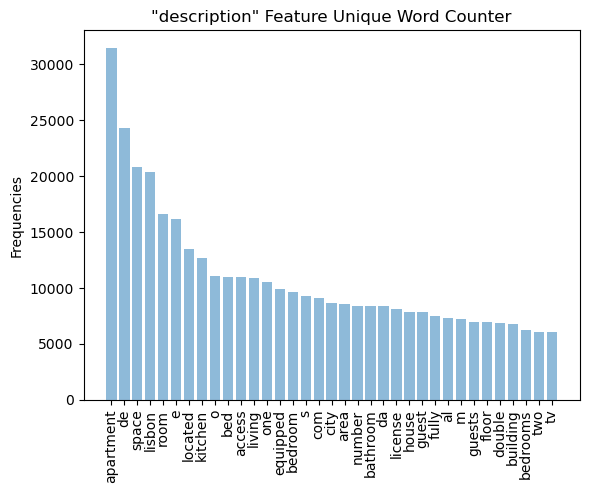

In [476]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqDescripWClean.index[0:35]
values = freqDescripWClean[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"description" Feature Unique Word Counter')

plt.show()

In [477]:
UniqueWDescriptionClean = sorted(set(allDescriptionWClean))
print('The number of unique words in the PreProcessed version of "description" is',len(UniqueWDescriptionClean))

The number of unique words in the PreProcessed version of "description" is 27990


In [478]:
print('The number of unique words in the original "description" is',len(allDescriptionW))

The number of unique words in the original "description" is 1648726


<div class="alert alert-block alert-success">
    Before the data preprocessing, we had <b>1.648.726</b> unique words after we reduced it to <b>27.990</b> words.

List of unique words in "description"

In [479]:
print(UniqueWDescriptionClean)

['a', 'aanwezig', 'aarroios', 'ab', 'aba', 'abade', 'abaiss', 'abaixo', 'abajo', 'abandoned', 'abano', 'abarracadas', 'abastados', 'abbaubarere', 'abelhas', 'abelheira', 'aben', 'abend', 'abends', 'aber', 'aberta', 'abertas', 'aberto', 'abertos', 'abertura', 'abgehend', 'abgeht', 'abgeschliffene', 'abgeschlossene', 'abgeschlossenem', 'abh', 'abholung', 'abide', 'abiente', 'ability', 'abklappern', 'able', 'ables', 'ably', 'aboard', 'abode', 'abonnement', 'abordagem', 'abou', 'abound', 'about', 'above', 'abovethe', 'abr', 'abra', 'abrace', 'abrangente', 'abre', 'abreise', 'abriga', 'abrigada', 'abrigado', 'abrigar', 'abrigo', 'abril', 'abrilmaio', 'abrir', 'abroad', 'abrunheira', 'abs', 'abschalten', 'abseits', 'absence', 'absense', 'absolu', 'absoluta', 'absolutamente', 'absolute', 'absolutely', 'absoluter', 'absolutly', 'absoluto', 'absorb', 'absorve', 'absorvido', 'absterse', 'abstract', 'absurdos', 'abund', 'abundam', 'abundance', 'abundant', 'abundantly', 'abuse', 'abusivo', 'abuts'

**host_about**

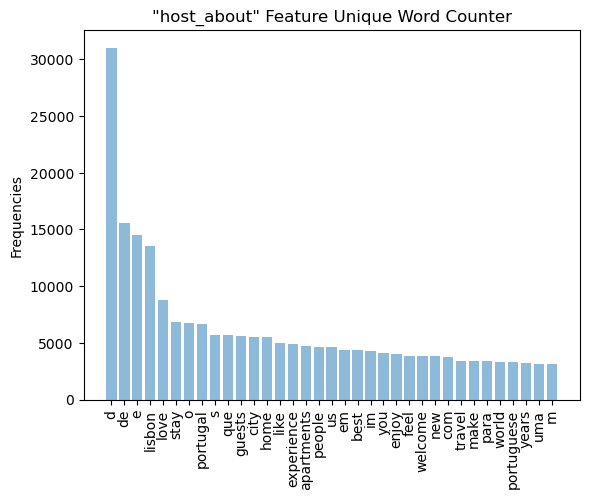

In [480]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqHostWClean.index[0:35]
values = freqHostWClean[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"host_about" Feature Unique Word Counter')

plt.show()

In [481]:
UniqueWHostClean = sorted(set(allHostWClean))
print('The number of unique words in the PreProcessed version of "host_about" is',len(UniqueWHostClean))

The number of unique words in the PreProcessed version of "host_about" is 19543


In [482]:
print('The number of unique words in the original "host_about" is',len(allHostW))

The number of unique words in the original "host_about" is 931865


<div class="alert alert-block alert-success">
    Before the data preprocessing, we had <b>931.865</b> unique words after we reduced it to <b>19.543</b> words.

In [496]:
print(UniqueWHostClean)

['a', 'aan', 'aangenaam', 'aansluit', 'ababuja', 'abandoned', 'abandonn', 'abbreviate', 'abelhasx', 'aben', 'abende', 'aber', 'aberta', 'abertas', 'aberto', 'abertos', 'ability', 'able', 'ables', 'ableton', 'aboard', 'aboardx', 'abordagem', 'aborrecido', 'abou', 'about', 'above', 'abra', 'abrem', 'abri', 'abrigitte', 'abrigo', 'abril', 'abrimos', 'abrindo', 'abrir', 'abriram', 'abrirvos', 'abro', 'abroad', 'abroadx', 'abs', 'abschluss', 'abseilingx', 'absence', 'absent', 'absoloutely', 'absolu', 'absolut', 'absolutamente', 'absolute', 'absolutelly', 'absolutely', 'absolutlety', 'absoluto', 'absorb', 'absorber', 'absorbing', 'absorved', 'absorvendo', 'absorves', 'absprechen', 'abstract', 'abu', 'abundam', 'abundancoa', 'aby', 'ac', 'acabamos', 'acabar', 'acabei', 'acaben', 'acabo', 'acad', 'academic', 'academics', 'academicx', 'academy', 'acamparx', 'acantilado', 'acarinhada', 'acarinhado', 'acaso', 'accelerator', 'accept', 'accepted', 'acceptons', 'acces', 'access', 'accesses', 'access

**comments**

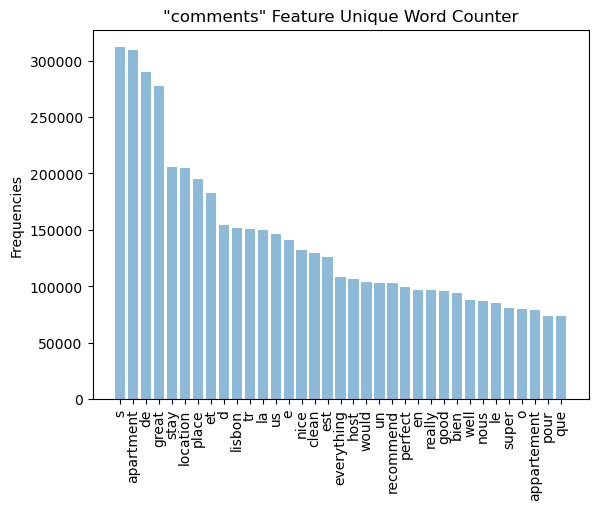

In [493]:
# Select the top 35 word frequencies and their corresponding labels
x_labels = freqCommentsWClean.index[0:35]
values = freqCommentsWClean[:35]

# Create a bar chart
plt.bar(x_labels, values, align='center', alpha=0.5)

# Set the x-axis labels and rotate them for better readability
plt.xticks(x_labels, rotation=90)
plt.ylabel('Frequencies')
plt.title('"comments" Feature Unique Word Counter')

plt.show()

In [494]:
UniqueWCommentsClean = sorted(set(allCommentsWClean))
print('The number of unique words in the PreProcessed version of "host_about" is',len(UniqueWCommentsClean))

The number of unique words in the PreProcessed version of "host_about" is 234046


In [495]:
print('The number of unique words in the original "host_about" is',len(allCommentsW))

The number of unique words in the original "host_about" is 34344857


<div class="alert alert-block alert-success">
    Before the data preprocessing, we had <b>34.344.857</b> unique words after we reduced it to <b>234.046</b> words.

In [498]:
#print(UniqueWCommentsClean)

In [64]:
clean_df_train_testTranslation.head()

description  \
0  com uma localiza o exclusiva entre vila de cas...   
1  hello traveler looking perfect location apartm...   
2  lapa district lisbons noble area find several ...   
3  um lugar ao sol place sun beach house located ...   
4  perfeito para pessoas muito aconchegante conta...   

                                          host_about  unlisted  \
0  hello im jos well prepared traveled love portu...         1   
1  hi world name jo o figueira years old counting...         0   
2  travelling decorating spaces eating meeting ne...         1   
3  couple loves travel meet cultures taste hiking...         0   
4  don t worry happy sunshine city lisbon always ...         1   

   description_count  host_count description_language host_language  
0                 86          26                   pt            en  
1                157         170                   en            en  
2                 53          36                   en            en  
3                178          96                   en            en  
4                158          38                   pt            en

## Translation

In [ ]:
def translate_text(text):
    translator = Translator(to_lang="en", from_lang="pt")
    translation = translator.translate(text)
    return translation

# Apply translation to the 'description' column when 'description_language' column is 'pt'
tqdm.pandas()  # Initialize tqdm to track the progress
clean_df_train_testTranslation['translated_description'] = clean_df_train_testTranslation.progress_apply(lambda x: translate_text(x['description']) if x['description_language'] == 'pt' else x['description'], axis=1)

# Print the updated DataFrame
print(clean_df_train_testTranslation)

In [69]:
# List of languages to translate
languages_to_translate = ['pt', 'fr', 'da', 'de', 'es', 'it', 'ca', 'no', 'nl', 'sv', 'ru', 'pl', 'zh-cn']

# Function to translate text to English
def translate_text(text):
    translator = Translator(to_lang="en")
    translation = translator.translate(text)
    return translation

# Apply translation to the 'description' column when 'description_language' is in the list of languages to translate
tqdm.pandas()  # Initialize tqdm to track the progress

# Create a new column 'translated_description' and initialize it with the original 'description' values
clean_df_train_testTranslation['translated_description'] = clean_df_train_testTranslation['description']

# Update 'translated_description' with translated text when necessary
mask = clean_df_train_testTranslation['description_language'].isin(languages_to_translate)
clean_df_train_testTranslation.loc[mask, 'translated_description'] = clean_df_train_testTranslation.loc[mask, 'description'].progress_apply(translate_text)

# Print the updated DataFrame
print(clean_df_train_testTranslation)

100%|███████████████████████████████████| 4063/4063 [00:00<00:00, 152636.95it/s]

                                             description  \
0      com uma localiza o exclusiva entre vila de cas...   
1      hello traveler looking perfect location apartm...   
2      lapa district lisbons noble area find several ...   
3      um lugar ao sol place sun beach house located ...   
4      perfeito para pessoas muito aconchegante conta...   
...                                                  ...   
21987  cat s bairro alto cozy apartment lisbon city c...   
21988  beautifully located heart lisbons historic cen...   
21989  enjoy breakfast sleek kitchen freestanding kno...   
21990  terra da eira uma casa de campo rodeada de rvo...   
21991  brandnew apartment combines elegant charme exc...   

                                              host_about  unlisted  \
0      hello im jos well prepared traveled love portu...         1   
1      hi world name jo o figueira years old counting...         0   
2      travelling decorating spaces eating meeting ne...         1   

In [75]:
import pandas as pd
from tqdm import tqdm
from translate import Translator

# List of languages to translate
languages_to_translate = ['pt', 'fr', 'da', 'de', 'es', 'it', 'ca', 'no', 'nl', 'sv', 'ru', 'pl', 'zh-cn']

# Function to translate text to English
def translate_text(text):
    translator = Translator(to_lang='en', from_lang='auto')
    translation = translator.translate(text)
    return translation

# Apply translation to the 'description' column when 'description_language' is in the list of languages to translate
tqdm.pandas()  # Initialize tqdm to track the progress

# Create a new column 'translated_description' and initialize it with the original 'description' values
clean_df_train_testTranslation['translated_description'] = clean_df_train_testTranslation['description']

# Update 'translated_description' with translated text when necessary
mask = clean_df_train_testTranslation['description_language'].isin(languages_to_translate)
clean_df_train_testTranslation.loc[mask, 'translated_description'] = clean_df_train_testTranslation.loc[mask, 'description'].progress_apply(translate_text)

# Print the updated DataFrame
print(clean_df_train_testTranslation)

100%|███████████████████████████████████████| 4063/4063 [23:13<00:00,  2.91it/s]

                                             description  \
0      com uma localiza o exclusiva entre vila de cas...   
1      hello traveler looking perfect location apartm...   
2      lapa district lisbons noble area find several ...   
3      um lugar ao sol place sun beach house located ...   
4      perfeito para pessoas muito aconchegante conta...   
...                                                  ...   
21987  cat s bairro alto cozy apartment lisbon city c...   
21988  beautifully located heart lisbons historic cen...   
21989  enjoy breakfast sleek kitchen freestanding kno...   
21990  terra da eira uma casa de campo rodeada de rvo...   
21991  brandnew apartment combines elegant charme exc...   

                                              host_about  unlisted  \
0      hello im jos well prepared traveled love portu...         1   
1      hi world name jo o figueira years old counting...         0   
2      travelling decorating spaces eating meeting ne...         1   

In [79]:
print(clean_df_train_testTranslation["translated_description"][0])

MYMEMORY WARNING: YOU USED ALL AVAILABLE FREE TRANSLATIONS FOR TODAY. NEXT AVAILABLE IN  09 HOURS 38 MINUTES 08 SECONDS VISIT HTTPS://MYMEMORY.TRANSLATED.NET/DOC/USAGELIMITS.PHP TO TRANSLATE MORE


In [115]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocesses a given sentence
def preprocess(sentence):
    # Convert the sentence to a string
    sentence = str(sentence)
    
    # Convert the sentence to lowercase
    sentence = sentence.lower()
    
    # Remove '{html}' from the sentence
    sentence = sentence.replace('{html}', "")
    
    # Remove HTML tags from the sentence
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    
    # Remove URLs from the sentence
    rem_url = re.sub(r'http\S+', '', cleantext)
    
    # Remove numbers from the sentence
    rem_num = re.sub('[0-9]+', '', rem_url)
    
    # Tokenize the sentence into individual words
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    
    # Filter out words that are less than 3 characters long and are stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    
    # Stem the filtered words
    stem_words = [stemmer.stem(w) for w in filtered_words]
    
    # Lemmatize the stemmed words
    lemma_words = [lemmatizer.lemmatize(w) for w in stem_words]
    
    # Join the filtered words back into a sentence
    return " ".join(filtered_words)

# Create a clean copy of the DataFrame and preprocess the "description" and "host_about" columns
df_train_clean = df_train
df_train_clean["description"] = df_train_clean["description"].map(lambda s: preprocess(s))
df_train_clean["host_about"] = df_train_clean["host_about"].map(lambda s: preprocess(s))

# Display the cleaned DataFrame
df_train_clean.head()


In [123]:
df_train_clean["host_about"] = df_train_clean["host_about"].map(lambda s:preprocess(s))

In [124]:
df_train_clean.head()

description  \
index                                                      
1      shared mixed room hostel shared bathroom locat...   
2      meu espaço fica perto parque eduardo vii salda...   
3      trafaria house cozy familiar villa facilities ...   
4      apartamento charmoso chiado entre largo carmo ...   
5      joli appartement bordure mer min pied plage vu...   

                                              host_about  unlisted  
index                                                               
1                              alojamento local registro         0  
2      friendly host try always around need anything ...         1  
3      social person liking communicate reading trave...         1  
4      hello _xd_ portuguese love meet people around ...         0  
5      nous sommes une famille avec deux enfants ans ...         0

## N-Grams
#### Create a new feature with n-grams
an n-gram is a contiguous sequence of n items from a given sample of text or speech

In [125]:
def ngrams(input, n):
    
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

In [126]:
nltk.download('punkt')
tags = ['0', '1']

df_train_bis = df_train_clean[df_train_clean.unlisted.isin(tags)]

# Create n-grams
df_train_bis['tokens'] = df_train_bis.apply(lambda row: nltk.word_tokenize(row['text'].strip()), axis=1)
df_train_bis['bi_Grams'] = df_train_bis.apply(lambda row: ngrams(row['tokens'], 2), axis=1)
df_train_bis['tri_Grams'] = df_train_bis.aply(lambda row: ngrams(row['tokens'], 3), axis=1)
print(len(df_train_bis),'samples from', len(tags),'decision')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedroanastacio/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


ValueError: Cannot set a DataFrame with multiple columns to the single column tokens

### Checking label proportion

### Checking for duplications

In [12]:
duplicated_descriptions = df_train_raw['description'][df_train_raw['description'].duplicated(keep=False)].unique()
duplicated_host_abouts = df_train_raw['host_about'][df_train_raw['host_about'].duplicated(keep=False)].unique()

print('The number of unique duplicated descriptions:', len(duplicated_descriptions))
print('The number of unique duplicated host_about values:', len(duplicated_host_abouts))

The number of unique duplicated descriptions: 365
The number of unique duplicated host_about values: 1673


In [13]:
duplicated_1 = "Saldanha Prestige is a classy and quality apartment that has been totally renovated this year in order to prepare the 9 rooms and all the common areas to welcome our Guests with all the best confort. From here you'll be able to enjoy all the best Lisboa has to offer! Come and stay with us - you're always welcome! I've been a proud Airbnb host for 2 years and have very good reviews.<br /><br /><b>The space</b><br />The apartment was totally renovated this year and has 7 rooms with shared bathrooms and 2 with their own private bathrooms. Included in the price are the common expenses, Wi-fi internet throughout the apartment, cleaning service of all common areas three times a week and also of the rooms once a week. Rooms are confortably furnished with good beds and guests are supplied with bath towels and bed linens.<br /><br /><b>Guest access</b><br />All the rooms have access to a beautiful living room with TV, a completely equiped kitchen with all equipments: tableware, fridges, freezer"

In [14]:
df_train_raw.loc[df_train_raw['description']==duplicated_1]

index                                        description   
98       99  Saldanha Prestige is a classy and quality apar...  \
3581   3582  Saldanha Prestige is a classy and quality apar...   
4090   4091  Saldanha Prestige is a classy and quality apar...   
4859   4860  Saldanha Prestige is a classy and quality apar...   
5381   5382  Saldanha Prestige is a classy and quality apar...   
6649   6650  Saldanha Prestige is a classy and quality apar...   
7378   7379  Saldanha Prestige is a classy and quality apar...   
8873   8874  Saldanha Prestige is a classy and quality apar...   

                                             host_about  unlisted  
98    Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
3581  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
4090  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
4859  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
5381  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
6649  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
7378  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0  
8873  Família_x000D_\nPortugal_x000D_\nGavião_x000D_...         0

In [15]:
duplicated_2 = '<b>Other things to note</b><br />For your information, we are carrying out work in the apartment and because of this the kitchen will not be available, for the month of February there will be men working from 9 am to 5 pm. To compensate, you pay much less than -50% of the price usual.<br /><br /><b>License number</b><br />104691/AL'

In [16]:
df_train_raw.loc[df_train_raw['description']==duplicated_2]

index                                        description host_about   
92       93  <b>Other things to note</b><br />For your info...          .  \
5352   5353  <b>Other things to note</b><br />For your info...          .   
9285   9286  <b>Other things to note</b><br />For your info...          .   

      unlisted  
92           1  
5352         0  
9285         1

<a class="anchor" id="ENG">

## 4 Feature Engineering

</a>

Apply at least 2 techniques
- TF-IDF
- Glove Embeddings

<a class="anchor" id="CLMODELS">

## 5 Classification Models

</a>

Apply at least 3 techniques
- KNN
- LR
- MLP
- LSTM

<a class="anchor" id="EVAL">

## 6 Evaluation
</a>

- Precision
- Recall
- Accuracy
- F1 Score